# Assignment 3 - Image Segmentation using MRFs

## GrabCut

---

**TA** : Avinash, Samartha  
**Release date**: 21/03/22  
**Submission date** : 02/04/22

---

For this assignment you will implement the GrabCut method mentioned in this [paper](https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf). It is essentially an iterative version of GraphCut as shown in the figure below.
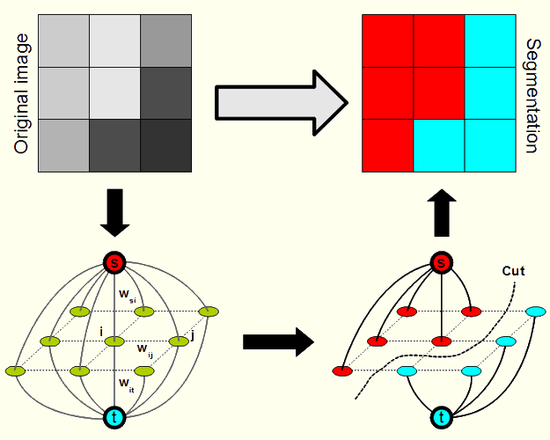

The code below takes an input image and follows these steps:

- It requires a bounding box to be drawn by the user to roughly segment out the foreground pixels
- It runs an initial min-cut optimization using the provided annotation
- The result of this optimization gives an initial segmentation
- To further refine this segmentation, the user provides two kinds of strokes to aid the optimization
  - strokes on the background pixels
  - strokes on the foreground pixels
- The algorithm now utilizes this to refine the original segmentation

You are allowed to use standard GMM libraries for the implementation. For usage of other libraries, please contact the TAs.

You can view this [video](https://www.youtube.com/watch?v=aOqOwM-Qbtg) to get a better idea of the steps involved.

Image segmentation is one exciting application of MRFs. You can further read about other applications of MRFs for Computer Vision [here](https://cedar.buffalo.edu/~srihari/CSE574/Chap8/Ch8-PGM-Undirected/9.5-MRFinCV.pdf).

#### Useful Links

- https://courses.engr.illinois.edu/cs543/sp2011/lectures/Lecture%2012%20-%20MRFs%20and%20Graph%20Cut%20Segmentation%20-%20Vision_Spring2011.pdf


In [337]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from igraph import Graph


In [406]:
def init_n_links(img, n=8, gamma=50):
    E = []
    W = []
    D = []
    h, w = img.shape[:2]
    Dy = [1, 0, 1, -1] if n == 8 else [1, 0]
    Dx = [0, 1, 1, 1] if n == 8 else [0, 1]
    for i in range(h):
        for j in range(w):
            for dy, dx in zip(Dy, Dx):
                y, x = i+dy, j+dx
                if x < 0 or x >= w or y < 0 or y >= h:
                    continue
                E.append((i*w+j, y*w+x))
                W.append(np.sum((img[i, j]-img[y, x])**2))
                D.append(np.sqrt(dx**2+dy**2))
    W = np.array(W)
    E = np.array(E)
    D = np.array(D)
    beta = 1 / (2 * np.mean(W))
    # gamma = 50
    W = gamma * np.exp(-beta * W)
    W /= D
    return E, W, np.max(W)


In [407]:
def init_t_links(img, trimap, k, K, weights, edges):
    GMM_b = GaussianMixture(n_components=k)
    GMM_f = GaussianMixture(n_components=k)
    # print(weights.shape, edges.shape)
    # print(img.shape)
    h, w = img.shape[:2]
    s, t = h*w, h*w + 1
    bgn = np.where(trimap == 0)
    unkn = np.where(trimap == 1)
    fgn = np.where(trimap == 2)

    fgn_or_unkn = np.where(trimap != 0)

    # posf = np.concatenate((fgn[0][...,None], fgn[1][..., None]), axis=1)
    # posb = np.concatenate((bgn[0][...,None], bgn[1][..., None]), axis=1)
    GMM_f.fit(img[fgn_or_unkn])
    GMM_b.fit(img[bgn])

    bgn_pix = img[bgn]
    fgn_pix = img[fgn]
    unkn_pix = img[unkn]

    unkn = unkn[0]*w + unkn[1]
    bgn = bgn[0]*w + bgn[1]
    fgn = fgn[0]*w + fgn[1]

    unkn = unkn.reshape(-1, 1)
    bgn = bgn.reshape(-1, 1)
    fgn = fgn.reshape(-1, 1)

    unkn_back = -GMM_f.score_samples(unkn_pix)
    unkn_front = -GMM_b.score_samples(unkn_pix)

    fgn_back = np.zeros((len(fgn), 1))
    fgn_front = np.full((len(fgn), 1), K)

    bgn_front = np.zeros((len(bgn), 1))
    bgn_back = np.full((len(bgn), 1), K)

    # val_f[bgn] = 0
    # val_b[bgn] = k
    weights = weights.reshape(-1, 1)
    edges = np.concatenate(
        (edges, np.hstack([np.full((len(unkn), 1), s), unkn])), axis=0)
    weights = np.concatenate((weights, unkn_front[..., None]))

    edges = np.concatenate(
        (edges, np.hstack([np.full((len(unkn), 1), t), unkn])), axis=0)
    weights = np.concatenate((weights, unkn_back[..., None]))

    edges = np.concatenate(
        (edges, np.hstack([np.full((len(bgn), 1), s), bgn])), axis=0)
    weights = np.concatenate((weights, bgn_front))

    edges = np.concatenate(
        (edges, np.hstack([np.full((len(bgn), 1), t), bgn])), axis=0)
    weights = np.concatenate((weights, bgn_back))

    edges = np.concatenate(
        (edges, np.hstack([np.full((len(fgn), 1), s), fgn])), axis=0)
    weights = np.concatenate((weights, fgn_front))

    edges = np.concatenate(
        (edges, np.hstack([np.full((len(fgn), 1), t), fgn])), axis=0)
    weights = np.concatenate((weights, fgn_back))
    return edges, weights


In [443]:
def grabCut(img, trimap, k=5, iter=3, n=8, gamma=50, each_iter=False):
    img = img.astype('float')
    h, w = img.shape[:2]
    s, t = h*w, h*w + 1
    bgn = np.where(trimap == 0)
    fgn = np.where(trimap == 2)
    bgn = bgn[0]*w + bgn[1]
    fgn = fgn[0]*w + fgn[1]
    for i in range(iter):
        # init n links
        E, W, K = init_n_links(img, n, gamma)
        # init t links
        E, W = init_t_links(img, trimap, k,  K, W, E)
        # print(E, W)
        W = W.flatten()
        # weighted_edges = np.concatenate([E, W.reshape(-1, 1)], axis=1)
        # print(weighted_edges)
        G = Graph()
        G.add_vertices(h*w + 2)
        G.add_edges(E)
        G.es['weight'] = W
        mincut = G.mincut(s, t, capacity='weight')
        # print(mincut.partition)
        x = np.array(mincut[0])
        y = np.array(mincut[1])
        # print(x,y)
        # Return node ids except source and sink
        x, y = x[:-1], y[:-1]
        trimap = np.zeros(h*w)
        trimap[x] = 1
        trimap[bgn] = 0
        trimap[fgn] = 2
        trimap = trimap.reshape((h, w))
        final = cv2.bitwise_and(img.astype('uint8'), img.astype(
            'uint8'), mask=trimap.astype('uint8'))
        if each_iter:
            plt.imshow(final)
            plt.show()
    trimap[fgn] = 1
    return final, trimap
    # print(x.shape, y.shape)


# Pre-written Code


In [341]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """

    def __init__(self, flags, img, _mask, colors):

        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img

    @image.setter
    def image(self, img):
        self.img = img

    @property
    def mask(self):
        return self._mask

    @mask.setter
    def mask(self, _mask):
        self._mask = _mask

    @property
    def flags(self):
        return self.FLAGS

    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags

    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_RBUTTONDOWN:
            self.FLAGS['DRAW_RECT'] = True
            self.ix, self.iy = x, y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy),
                              (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(
                    self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_RBUTTONUP:
            self.FLAGS['DRAW_RECT'] = False
            self.FLAGS['rect_over'] = True
            cv2.rectangle(self.img, (self.ix, self.iy),
                          (x, y), self.COLORS['BLUE'], 2)
            self.FLAGS['RECT'] = (min(self.ix, x), min(
                self.iy, y), abs(self.ix - x), abs(self.iy - y))
            self.FLAGS['rect_or_mask'] = 0

        # Draw strokes for refinement

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x, y), 3,
                           self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3,
                           self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3,
                           self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3,
                           self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3,
                           self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3,
                           self.FLAGS['value']['val'], -1)


In [342]:
def run(filename: str):
    """
    Main loop that implements GrabCut. 

    Input
    -----
    filename (str) : Path to image
    """

    COLORS = {
        'BLACK': [0, 0, 0],
        'RED': [0, 0, 255],
        'GREEN': [0, 255, 0],
        'BLUE': [255, 0, 0],
        'WHITE': [255, 255, 255]
    }

    DRAW_BG = {'color': COLORS['BLACK'], 'val': 0}
    DRAW_FG = {'color': COLORS['WHITE'], 'val': 2}

    FLAGS = {
        'RECT': (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT': False,          # flag for drawing rectangle
        'rect_over': False,          # flag to check if rectangle is  drawn
        'rect_or_mask': -1,          # flag for selecting rectangle or stroke mode
        'value': DRAW_FG,            # drawing strokes initialized to mark foreground
    }

    img = cv2.imread(filename)
    img2 = img.copy()
    # mask is a binary array with : 0 - background pixels
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    #                               1 - foreground pixels
    output = np.zeros(img.shape, np.uint8)           # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')

    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)

    while(1):

        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        cv2.imshow('Segmented image', output)
        cv2.imshow('Input Image', img)

        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            break

        elif k == ord('0'):
            # Strokes for background
            FLAGS['value'] = DRAW_BG

        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG

        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype=np.uint8)
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)

        elif k == 13:
            # Press carriage return to initiate segmentation

            #-------------------------------------------------#
            # Implement GrabCut here.                         #
            # Function should return a mask which can be used #
            # to segment the original image as shown on L90   #
            #-------------------------------------------------#
            EventObj.flags = FLAGS
            rect = FLAGS['RECT']
            bbox = ((rect[0], rect[1]), (rect[0]+rect[3], rect[1]+rect[2]))
            mask = np.zeros(img2.shape[:2], dtype=np.uint8)
            mask[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1]] = 1
            # plt.imshow(mask)
            # plt.show()
            try:
                mask = grabCut(img2, mask, k=5, iter=3, n=8)
                mask2 = np.where((mask == 1), 255, 0).astype('uint8')
                cv2.imwrite(filename[:-3]+"bmp", mask2)
                output = cv2.bitwise_and(img2, img2, mask=mask2)
                plt.imshow(output)
                plt.show()
            except Exception as e:
                print(e)


# Run


QObject::moveToThread: Current thread (0x5607f5a686b0) is not the object's thread (0x5607f5c93c30).
Cannot move to target thread (0x5607f5a686b0)

QObject::moveToThread: Current thread (0x5607f5a686b0) is not the object's thread (0x5607f5c93c30).
Cannot move to target thread (0x5607f5a686b0)

QObject::moveToThread: Current thread (0x5607f5a686b0) is not the object's thread (0x5607f5c93c30).
Cannot move to target thread (0x5607f5a686b0)

QObject::moveToThread: Current thread (0x5607f5a686b0) is not the object's thread (0x5607f5c93c30).
Cannot move to target thread (0x5607f5a686b0)

QObject::moveToThread: Current thread (0x5607f5a686b0) is not the object's thread (0x5607f5c93c30).
Cannot move to target thread (0x5607f5a686b0)

QObject::moveToThread: Current thread (0x5607f5a686b0) is not the object's thread (0x5607f5c93c30).
Cannot move to target thread (0x5607f5a686b0)

QObject::moveToThread: Current thread (0x5607f5a686b0) is not the object's thread (0x5607f5c93c30).
Cannot move to tar

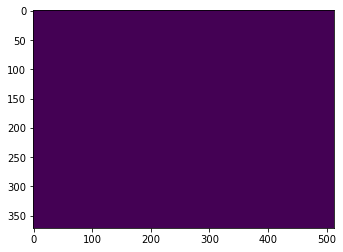

Found array with 1 sample(s) (shape=(1, 3)) while a minimum of 2 is required.
Draw the rectangle first.


In [343]:
if __name__ == '__main__':
    filename = '../images/llama.jpg'               # Path to image file
    run(filename)
    cv2.destroyAllWindows()


# Experimentation


In [496]:
name = "person6"
img = cv2.imread(f'../images/{name}.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
mask = np.zeros(img.shape[:2], dtype=np.uint8)
bbox = ((110, 120), (520, 310))
mask[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1]] = 1


(600, 450, 3)


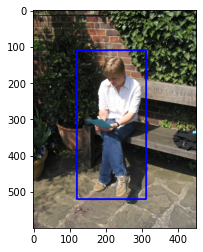

In [497]:
rect_img = img.copy()
cv2.rectangle(rect_img, bbox[0][::-1], bbox[1]
              [::-1], color=(0, 0, 255), thickness=3)
plt.imshow(rect_img)
plt.show()


In [385]:
final, mask = grabCut(img, mask, iter=3)


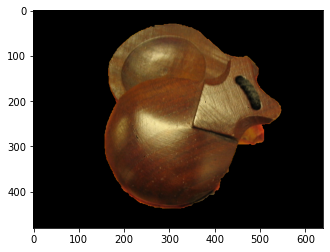

In [386]:
plt.imshow(final)
plt.show()


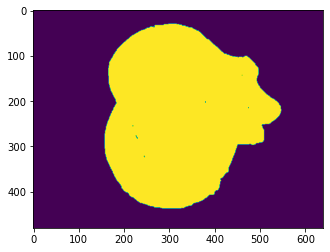

In [387]:
plt.imshow(mask)
plt.show()


In [388]:
cv2.imwrite(f"../output/{name}.jpg", final)
cv2.imwrite(f"../output/masks/{name}.bmp", mask*255)


True

# Evaluation Metrics


In [400]:
def calc_accuracy(mask1, mask2):
    assert(mask1.shape == mask2.shape)
    h, w = mask1.shape[:2]
    return np.count_nonzero(mask1 == mask2) / (h * w)


In [396]:
def calc_iou(mask1, mask2):
    assert(mask1.shape == mask2.shape)
    aa = cv2.bitwise_and(mask1, mask2)
    oo = cv2.bitwise_or(mask1, mask2)
    return np.count_nonzero(aa) / np.count_nonzero(oo)


In [397]:
def calc_dice(mask1, mask2):
    assert(mask1.shape == mask2.shape)
    oo = cv2.bitwise_and(mask1, mask2)
    h, w = mask1.shape[:2]
    return np.count_nonzero(oo) / (h*w)


In [405]:
# recurse over globs
import glob
import os

l = list(glob.glob('../ground_truth/*.bmp'))
l = sorted(l)
for x in l:
    basename = os.path.basename(x)
    mask1 = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    mask2 = cv2.imread(f'../output/masks/{basename}', cv2.IMREAD_GRAYSCALE)
    mask1[mask1 == 255] = 1
    mask2[mask2 == 255] = 1
    # mask2 /= 255
    print(basename, "acc:", calc_accuracy(mask1, mask2), "jaccard:",
          calc_iou(mask1, mask2), "dice:", calc_dice(mask1, mask2))


banana1.bmp acc: 0.97181640625 jaccard: 0.9007121477964702 dice: 0.255673828125
banana2.bmp acc: 0.99236328125 jaccard: 0.9682672798593264 dice: 0.23302083333333334
banana3.bmp acc: 0.9843326822916667 jaccard: 0.9372408397444256 dice: 0.233974609375
book.bmp acc: 0.9781966145833333 jaccard: 0.9441670487225441 dice: 0.36870768229166667
bool.bmp acc: 0.9337863247863248 jaccard: 0.6523748625788068 dice: 0.12426068376068376
bush.bmp acc: 0.9612518518518518 jaccard: 0.7770864849892399 dice: 0.13507777777777777
ceramic.bmp acc: 0.9739908854166667 jaccard: 0.9212054870171494 dice: 0.30407877604166667
cross.bmp acc: 0.9055296296296297 jaccard: 0.74536034102367 dice: 0.27652592592592595
doll.bmp acc: 0.9903366214841625 jaccard: 0.9739701150157709 dice: 0.36157831239798455
elefant.bmp acc: 0.9629329427083333 jaccard: 0.8965626873535236 dice: 0.32128580729166667
flower.bmp acc: 0.9966074074074074 jaccard: 0.9827761272611034 dice: 0.19357777777777777
fullmoon.bmp acc: 0.996677440206852 jaccard: 0.

In [344]:
import time


def segmentation(name, mask):
    img = cv2.imread(f'../images/{name}.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    mask[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1]] = 1
    t1 = time.perf_counter()
    final, mask = grabCut(img, mask, iter=3)
    t2 = time.perf_counter()
    print(f"Time take for {name}", t2-t1)
    plt.imshow(final)
    plt.show()


In [358]:
good = ["flower", "teddy", "stone2", "llama"]
good_bbox = [((70, 150), (400, 470)),
             ((50, 50), (350, 250)),
             ((10, 190), (450, 510)),
             ((100, 110), (371, 370))]
bad = ["tennis", "bush"]
bad_bbox = [((100, 130), (460, 330)), ((50, 130), (550, 330))]


Time take for flower 33.982673053000326


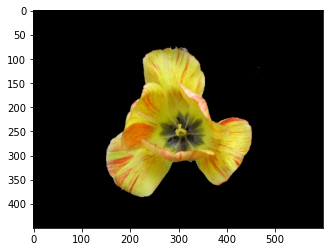

Time take for teddy 14.541151950999847


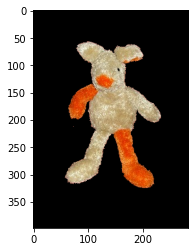

Time take for stone2 42.505249438001556


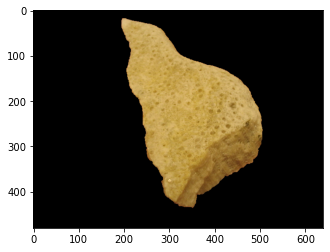

Time take for llama 27.242990992999694


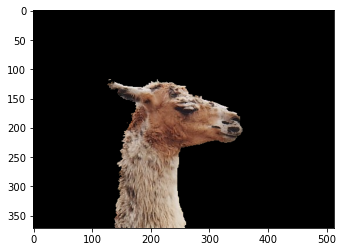

In [359]:
for img, bbox in zip(good, good_bbox):
    segmentation(img, bbox)


Time take for tennis 28.965379102999577


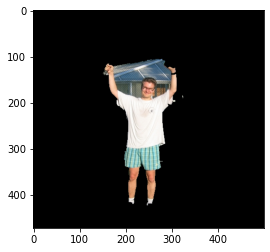

Time take for bush 36.179051828999945


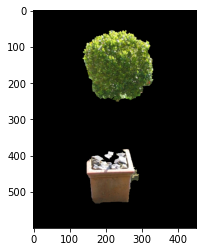

In [360]:
for img, bbox in zip(bad, bad_bbox):
    segmentation(img, bbox)


# Report


In [445]:
img = cv2.imread(f'../images/book.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = np.zeros(img.shape[:2], dtype=np.uint8)
bbox = ((30, 80), (460, 610))
mask[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1]] = 1

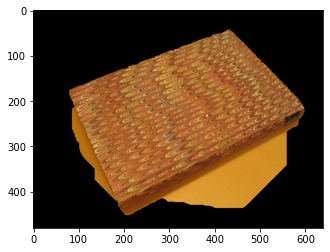

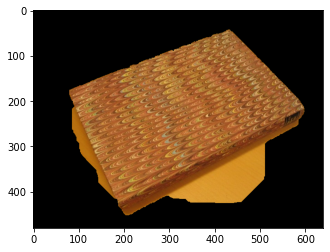

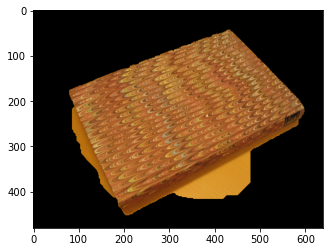

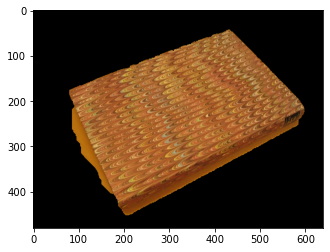

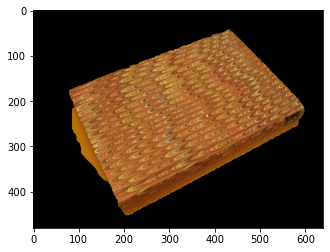

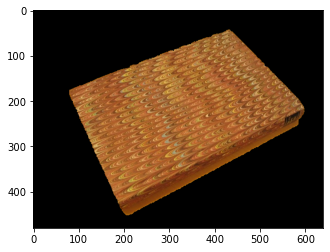

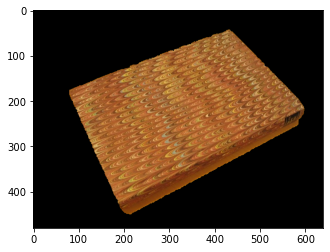

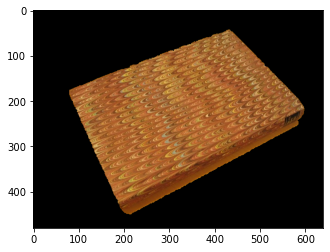

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,

In [446]:
# The number of iterations of GMM updating and energy minimization
grabCut(img, mask, iter=8, each_iter=True)

We can see in this case that more iterations lead to a better performance,as the region on which GMMs are trained is refined from iteration to iteration and thus leads to better segmentation. However this is also not true in every case as more iterations might lead to cuts that distort the foreground.

In [498]:
img = cv2.imread(f'../images/person6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = np.zeros(img.shape[:2], dtype=np.uint8)
bbox = ((110, 120), (520, 310))
mask[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1]] = 1

k=1


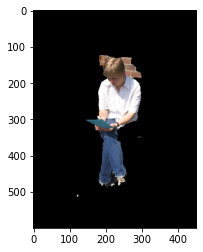

k=2


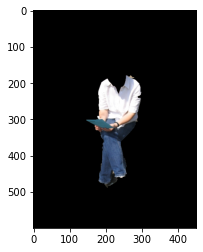

k=3


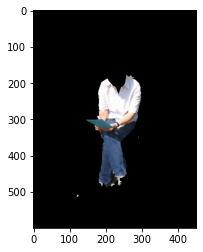

k=4


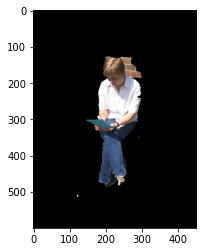

k=5


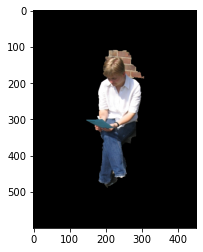

In [500]:
# The number of mixture components in your GMM
print("k=1")
final, mask1 = grabCut(img, mask, k=1)
plt.imshow(final)
plt.show()
print("k=2")
final, mask2 = grabCut(img, mask, k=2)
plt.imshow(final)
plt.show()
print("k=3")
final, mask3 = grabCut(img, mask, k=3)
plt.imshow(final)
plt.show()
print("k=4")
final, mask4 = grabCut(img, mask, k=4)
plt.imshow(final)
plt.show()
print("k=5")
final, mask5 = grabCut(img, mask, k=5)
plt.imshow(final)
plt.show()

The GMM initialization depends upon a scheme to cluster pixels based upon their color. We can see from the above Higher number of components(but not too high) lead to better results.

In [469]:
img = cv2.imread(f'../images/grave.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = np.zeros(img.shape[:2], dtype=np.uint8)
bbox = ((150, 140), (460, 360))
mask[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1]] = 1

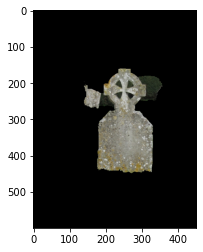

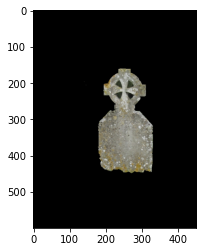

In [470]:
# 4-neighborhood or 8-neighborhood in your pairwise term
final, mask1 = grabCut(img, mask, n=4)
plt.imshow(final)
plt.show()
final, mask1 = grabCut(img, mask, n=8)
plt.imshow(final)
plt.show()

Eight neighbourhood leads to more information and the neighborhood around the node is better defined. I have also divided by the distance because Without the distance term, GrabCut displays a tendancy towards diagonal cuts. The results above show that. The area around the circle is easily cut in the 8n case.

In [415]:
img = cv2.imread(f'../images/llama.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = np.zeros(img.shape[:2], dtype=np.uint8)
bbox = ((100, 110), (371, 370))
mask[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1]] = 1

Gamma=1


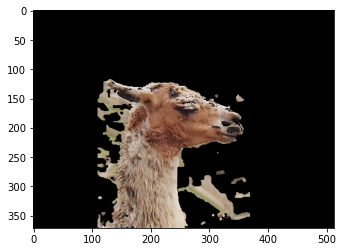

Gamma=20


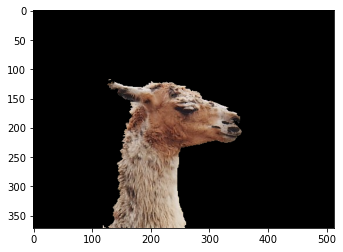

Gamma=50


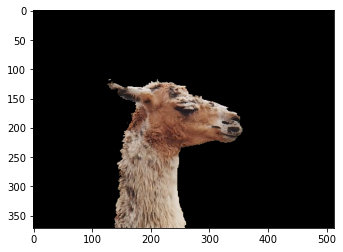

Gamma=200


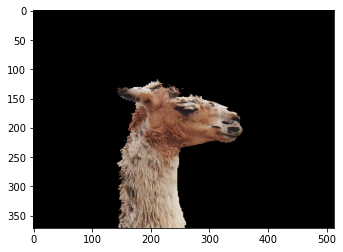

Gamma=5000


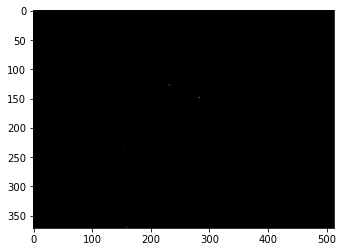

In [417]:
# The choice of gamma
print("Gamma=1")
final, mask1 = grabCut(img, mask, iter=3, gamma=1)
plt.imshow(final)
plt.show()
print("Gamma=20")
final, mask2 = grabCut(img, mask, iter=3, gamma=20)
plt.imshow(final)
plt.show()
print("Gamma=50")
final, mask3 = grabCut(img, mask, iter=3, gamma=50)
plt.imshow(final)
plt.show()
print("Gamma=200")
final, mask4 = grabCut(img, mask, iter=3, gamma=200)
plt.imshow(final)
plt.show()
print("Gamma=500")
final, mask5 = grabCut(img, mask, iter=3, gamma=500)
plt.imshow(final)
plt.show()

The gamma parameter causes the smoothening of the boundary, because hard boundaries have even larger weights. This is aparrent on the fur of the llama. This is because weight of n links is directly proportional to gamma 

In [430]:
img = cv2.imread(f'../images/banana1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = np.zeros(img.shape[:2], dtype=np.uint8)
bbox = ((30, 30), (440, 610))
mask[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1]] = 1

RGB


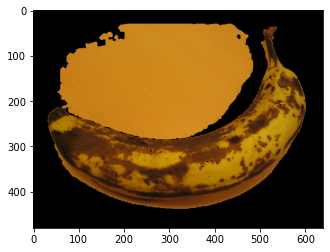

HSV


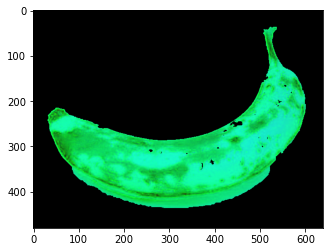

YCRCB


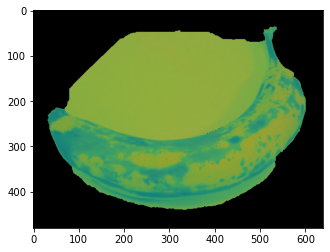

LAB


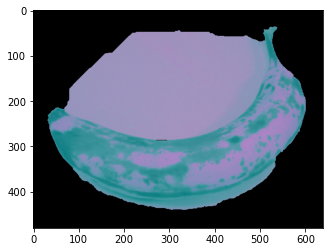

In [431]:
# Different color spaces or ways of representing pixels
# The choice of gamma
print("RGB")
final, mask1 = grabCut(img, mask, iter=3, gamma=1)
plt.imshow(final)
plt.show()
print("HSV")
img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
final, mask2 = grabCut(img, mask, iter=3, gamma=20)
plt.imshow(final)
plt.show()
img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
print("YCRCB")
img = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
final, mask3 = grabCut(img, mask, iter=3, gamma=50)
plt.imshow(final)
plt.show()
img = cv2.cvtColor(img, cv2.COLOR_YCR_CB2RGB)
print("LAB")
img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
final, mask3 = grabCut(img, mask, iter=3, gamma=50)
plt.imshow(final)
plt.show()

The choice of the color space matters, and we can see this is the banana image the color distribution of the foreground and the background is very close in the RGB colorspace but in the HSV colorspace this is not true thus better results are shown. LAB does not remove this similarity in color distribution.